In [104]:
import numpy as np
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import load_model
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel) # input image dimensions
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

print('Dimensión Datos entrenamiento = ', x_train.shape)
print('Dimensión Datos de testeo = ', x_test.shape)

Dimensión Datos entrenamiento =  (60000, 28, 28, 1)
Dimensión Datos de testeo =  (10000, 28, 28, 1)


#Análisis y visualización de datos

En lo anterior, se normalizaron los datos de entrenamiento y de test.  Abajo, es posible ver una visualización de los 10 primeros datos. Son imágenes de 10 categorías distintas en las cuales cada categría posee una imagen de su número en distintas formas.

Se realizó un histograma para ver la frecuancia con la que aparecen cada uno de los números y, en general, están 'bien' distribuidos ( con ello nos referimos a que no existe una categoría dominante, en cuanto a frencuencias respecta). Así al momento de entrenar el modelo, éste no tenderá a aprenderse alguna respuesta. Por ello, que al momento de realizar el *split* de los datos de entrenamiento se estratificarán. 

   Frecuencia
1        5394
6        4734
2        4766
8        4681
0        4738
7        5012
4        4674
9        4759
5        4337
3        4905


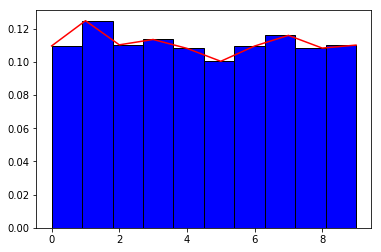

In [189]:
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd


cnt = Counter()
for k in y_train:
  cnt[k]+=1
freq = dict(cnt)

a,b,c = plt.hist(y_train, color = 'blue', edgecolor = 'black', density = True, )
plt.plot(a,  color= 'red')

print(pd.DataFrame(freq, index = ['Frecuencia']).T)



(-0.5, 27.5, 27.5, -0.5)

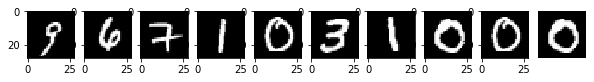

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i in range(10):
  n = np.random.randint(100)
  plt.subplot(1,10, i+1)
  plt.imshow(x_train[n].reshape(28,28), cmap = 'gray')
  
plt.axis('off')

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size = 0.2, stratify = y_train)



En lo que sigue se realizarán los testeos correspondientes a los datos. Por un lado, se probará un modelo de autoencoder simple, con una capa densa de tamaño *d=2,8,16,32*. Se estudiarán los tiempos de ejecución y se verá cuál función de activación (ReLu o Sigmoid) es más adecuada en este caso. 

A primera vista, como hipótesis, la función ReLu podría tener un mejor desempeño debido a la forma en que se normalizaron los datos. Ellos no explotan en la parte negativa por lo tanto deberían funcionar bien.  Por otro lado, se probaron 3 métricas distintas(MSE, binary_crossentropy yMSLE) y se decidió actuar con MSE para el entrenamiento del modelo, debido a un mejor desempeño. Por último,  se utilizará la medida *structural similarity index* para realizar una mejor comparación de las imágenes entregadas por el autoencoder y estudiar cuánto % de la imagen original se *perdió* en la reconstrucción. Se utilizará esta medida debido a que MSE malinterpreta la similitud de objeto cuando de imágenes se refiere. Esto debido a que toma bastante diferencia entre un una entrada que tiene valor 2 y otra con entrada valor 6, cuando en realidad no pareciera tanta la diferencia. 

Luego, su estudiará un *autoencoder* más profundo utilizando capas convolucionales para reducir las dimensionalidad de los datos. En ello se testeará también para las mismas dimensiones nombradas anteriormente y, junto con lo anterior, se utilizará PCA para poder comparar los 8 modelos descritos anteriorme.

Nada más que agregar, procedamos a estudiar los datos. En lo que sigue la descripción y análisis de los modelos se hará al final de ellos.




In [0]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model




def ae_dense(x_train, x_val, compres_dim, acti):
  input_img = Input(shape=original_img_size)
  input_fl = Flatten()(input_img) #to get a vector representation
  encoded = Dense(compres_dim, activation=acti)(input_fl)
  decoded = Dense(np.prod(original_img_size), activation='relu')(encoded)
  decoded = Reshape(original_img_size)(decoded)
  autoencoder = Model(inputs=input_img, outputs=decoded)
  encoder = Model(inputs=input_img, outputs=encoded)
  autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error', metrics = ['accuracy'])
  hist = autoencoder.fit(x_train,x_train,epochs=20,batch_size=32,validation_data=(x_val,x_val))
  autoencoder.save('basic_autoencoder.h5')
  encoder.save('basic_encoder.h5')
  return(hist)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 20s 408us/step - loss: 0.0718 - acc: 0.7992 - val_loss: 0.0701 - val_acc: 0.7997
Epoch 2/20
48000/48000 [==============================] - 8s 173us/step - loss: 0.0700 - acc: 0.7993 - val_loss: 0.0695 - val_acc: 0.8008
Epoch 3/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0696 - acc: 0.7998 - val_loss: 0.0694 - val_acc: 0.8006
Epoch 4/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0695 - acc: 0.7997 - val_loss: 0.0693 - val_acc: 0.8010
Epoch 5/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0695 - acc: 0.7997 - val_loss: 0.0692 - val_acc: 0.7996
Epoch 6/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0695 - acc: 0.7996 - val_loss: 0.0692 - val_acc: 0.8000
Epoch 7/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0695 - acc: 0.7996 - val_loss: 0.0692 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 389us/step - loss: 0.0469 - acc: 0.8042 - val_loss: 0.0430 - val_acc: 0.8059
Epoch 2/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0426 - acc: 0.8053 - val_loss: 0.0420 - val_acc: 0.8060
Epoch 3/20
48000/48000 [==============================] - 8s 175us/step - loss: 0.0420 - acc: 0.8053 - val_loss: 0.0421 - val_acc: 0.8051
Epoch 4/20
48000/48000 [==============================] - 8s 168us/step - loss: 0.0418 - acc: 0.8053 - val_loss: 0.0417 - val_acc: 0.8058
Epoch 5/20
48000/48000 [==============================] - 8s 169us/step - loss: 0.0417 - acc: 0.8053 - val_loss: 0.0417 - val_acc: 0.8060
Epoch 6/20
48000/48000 [==============================] - 8s 169us/step - loss: 0.0417 - acc: 0.8053 - val_loss: 0.0416 - val_acc: 0.8057
Epoch 7/20
48000/48000 [==============================] - 8s 169us/step - loss: 0.0417 - acc: 0.8053 - val_loss: 0.0416 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 394us/step - loss: 0.0355 - acc: 0.8083 - val_loss: 0.0301 - val_acc: 0.8108
Epoch 2/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0295 - acc: 0.8104 - val_loss: 0.0292 - val_acc: 0.8110
Epoch 3/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0290 - acc: 0.8105 - val_loss: 0.0288 - val_acc: 0.8109
Epoch 4/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0289 - acc: 0.8106 - val_loss: 0.0290 - val_acc: 0.8109
Epoch 5/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0288 - acc: 0.8106 - val_loss: 0.0286 - val_acc: 0.8111
Epoch 6/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0288 - acc: 0.8106 - val_loss: 0.0286 - val_acc: 0.8111
Epoch 7/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0287 - acc: 0.8106 - val_loss: 0.0286 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 393us/step - loss: 0.0273 - acc: 0.8114 - val_loss: 0.0213 - val_acc: 0.8138
Epoch 2/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0207 - acc: 0.8135 - val_loss: 0.0204 - val_acc: 0.8142
Epoch 3/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0201 - acc: 0.8137 - val_loss: 0.0206 - val_acc: 0.8140
Epoch 4/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0196 - acc: 0.8138 - val_loss: 0.0192 - val_acc: 0.8143
Epoch 5/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0194 - acc: 0.8138 - val_loss: 0.0191 - val_acc: 0.8143
Epoch 6/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0193 - acc: 0.8138 - val_loss: 0.0191 - val_acc: 0.8143
Epoch 7/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0193 - acc: 0.8138 - val_loss: 0.0192 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


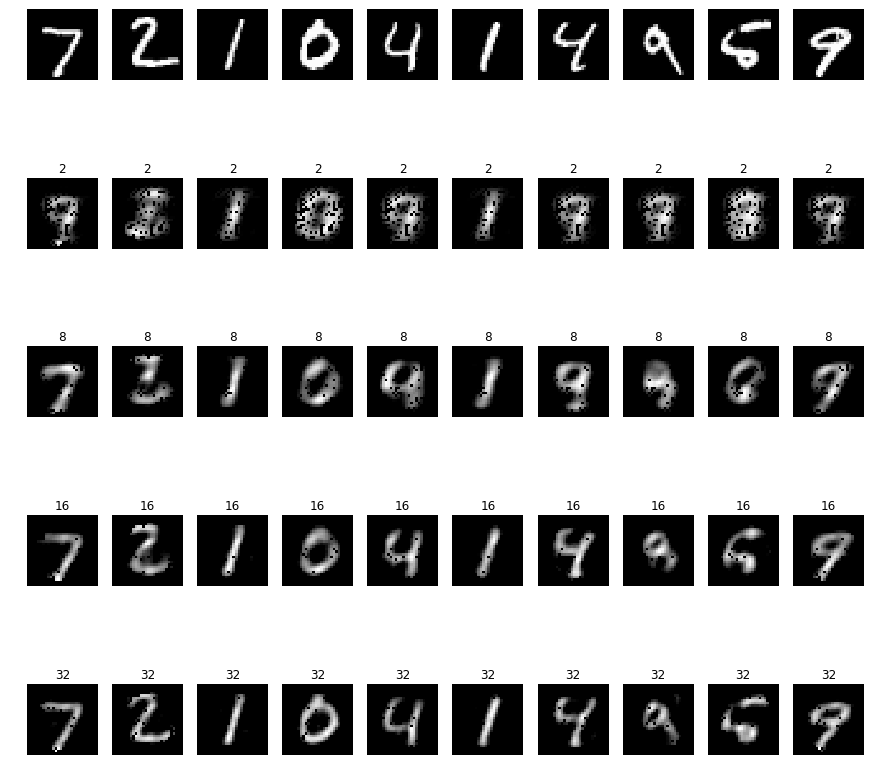

In [192]:
from keras.models import load_model
list_dim = [2,8,16,32]
models_ae_list = []
models_en_list = []
a = 0
plt.figure(figsize = (15,15))
for dim in list_dim:
  a = a +10
  x = ae_dense(x_train,x_val, dim, 'relu')
  model1 = load_model('basic_autoencoder.h5')
  models_ae_list = models_ae_list + [model1]
  model2 = load_model('basic_encoder.h5')
  models_en_list = models_en_list + [model2]
  y_pred = model1.predict(x_test)
  y_encode = model2.predict(x_test)
  for k in range(10):
    plt.subplot(5,10, k+1+a)
    plt.imshow(y_pred[k].reshape(28,28), cmap = 'gray')
    plt.title(str(dim))
    plt.axis('off')
for i in range(10):
  plt.subplot(5,10,i+1)
  plt.imshow(x_test[i].reshape(28,28), cmap='gray')
  plt.axis('off')

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 20s 421us/step - loss: 0.0793 - acc: 0.8026 - val_loss: 0.0753 - val_acc: 0.8008
Epoch 2/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0747 - acc: 0.8005 - val_loss: 0.0741 - val_acc: 0.8011
Epoch 3/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0741 - acc: 0.8004 - val_loss: 0.0738 - val_acc: 0.8011
Epoch 4/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0740 - acc: 0.8004 - val_loss: 0.0737 - val_acc: 0.8005
Epoch 5/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0739 - acc: 0.8003 - val_loss: 0.0736 - val_acc: 0.8010
Epoch 6/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0738 - acc: 0.8002 - val_loss: 0.0736 - val_acc: 0.8007
Epoch 7/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0738 - acc: 0.8002 - val_loss: 0.0735 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 398us/step - loss: 0.0593 - acc: 0.8041 - val_loss: 0.0483 - val_acc: 0.8043
Epoch 2/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0469 - acc: 0.8043 - val_loss: 0.0458 - val_acc: 0.8051
Epoch 3/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0455 - acc: 0.8048 - val_loss: 0.0451 - val_acc: 0.8054
Epoch 4/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0451 - acc: 0.8049 - val_loss: 0.0449 - val_acc: 0.8053
Epoch 5/20
48000/48000 [==============================] - 8s 170us/step - loss: 0.0448 - acc: 0.8050 - val_loss: 0.0448 - val_acc: 0.8051
Epoch 6/20
48000/48000 [==============================] - 8s 168us/step - loss: 0.0447 - acc: 0.8050 - val_loss: 0.0446 - val_acc: 0.8056
Epoch 7/20
48000/48000 [==============================] - 8s 168us/step - loss: 0.0446 - acc: 0.8050 - val_loss: 0.0446 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 402us/step - loss: 0.0512 - acc: 0.8059 - val_loss: 0.0390 - val_acc: 0.8084
Epoch 2/20
48000/48000 [==============================] - 8s 174us/step - loss: 0.0365 - acc: 0.8088 - val_loss: 0.0351 - val_acc: 0.8096
Epoch 3/20
48000/48000 [==============================] - 9s 178us/step - loss: 0.0345 - acc: 0.8096 - val_loss: 0.0340 - val_acc: 0.8101
Epoch 4/20
48000/48000 [==============================] - 8s 176us/step - loss: 0.0337 - acc: 0.8099 - val_loss: 0.0335 - val_acc: 0.8105
Epoch 5/20
48000/48000 [==============================] - 8s 174us/step - loss: 0.0334 - acc: 0.8100 - val_loss: 0.0332 - val_acc: 0.8104
Epoch 6/20
48000/48000 [==============================] - 8s 174us/step - loss: 0.0332 - acc: 0.8101 - val_loss: 0.0331 - val_acc: 0.8107
Epoch 7/20
48000/48000 [==============================] - 8s 173us/step - loss: 0.0330 - acc: 0.8101 - val_loss: 0.0329 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 19s 401us/step - loss: 0.0398 - acc: 0.8086 - val_loss: 0.0270 - val_acc: 0.8124
Epoch 2/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0246 - acc: 0.8126 - val_loss: 0.0231 - val_acc: 0.8137
Epoch 3/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0226 - acc: 0.8132 - val_loss: 0.0222 - val_acc: 0.8138
Epoch 4/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0219 - acc: 0.8134 - val_loss: 0.0219 - val_acc: 0.8139
Epoch 5/20
48000/48000 [==============================] - 8s 171us/step - loss: 0.0216 - acc: 0.8135 - val_loss: 0.0215 - val_acc: 0.8140
Epoch 6/20
48000/48000 [==============================] - 8s 173us/step - loss: 0.0214 - acc: 0.8135 - val_loss: 0.0213 - val_acc: 0.8140
Epoch 7/20
48000/48000 [==============================] - 8s 172us/step - loss: 0.0213 - acc: 0.8136 - val_loss: 0.0212 -

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


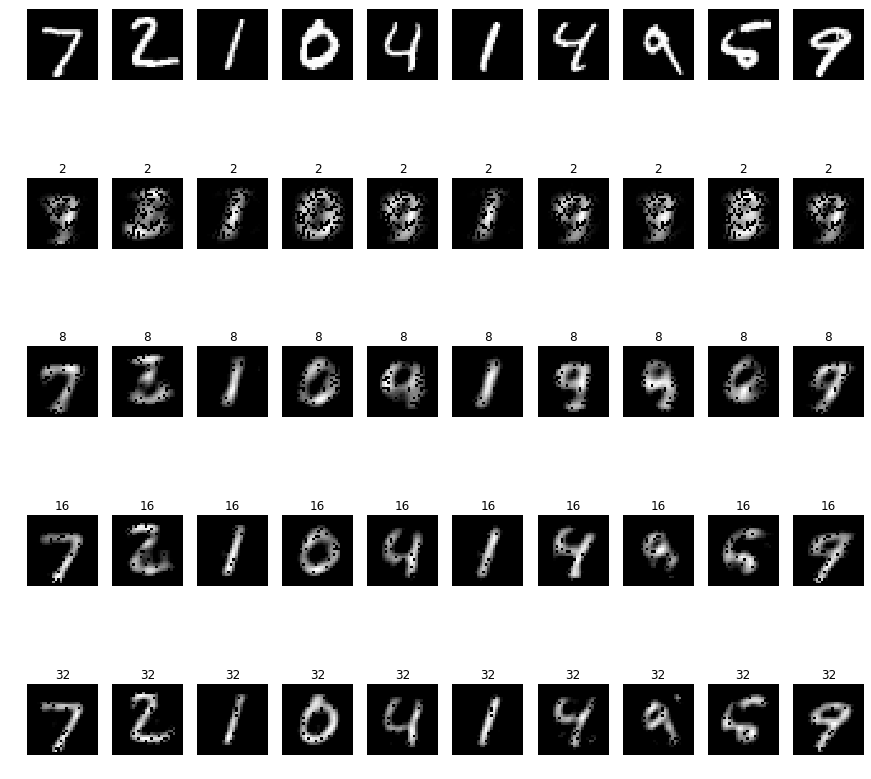

In [193]:
models_ae_list_sig = []
models_en_list_sig = []
a = 0
plt.figure(figsize = (15,15))
for dim in list_dim:
  a = a +10
  x = ae_dense(x_train,x_val, dim, 'sigmoid')
  model1 = load_model('basic_autoencoder.h5')
  models_ae_list_sig = models_ae_list_sig + [model1]
  model2 = load_model('basic_encoder.h5')
  models_en_list_sig = models_en_list_sig + [model2]
  y_pred = model1.predict(x_test)
  y_encode = model2.predict(x_test)
  for k in range(10):
    plt.subplot(5,10, k+1+a)
    plt.imshow(y_pred[k].reshape(28,28), cmap = 'gray')
    plt.title(str(dim))
    plt.axis('off')
for i in range(10):
  plt.subplot(5,10,i+1)
  plt.imshow(x_test[i].reshape(28,28), cmap='gray')
  plt.axis('off')

In [245]:
from skimage.measure import compare_ssim as ssim
alea = np.random.randint(low = 0, high = x_test.shape[0], size = (50,1))

list_relu =[]
list_sig = []
for i in alea:

  im_pred_relu = models_ae_list[3].predict(x_test)
  im_pred_sig = models_ae_list_sig[3].predict(x_test)
  score_relu = ssim(x_test[i[0]], im_pred_relu[i[0]], multichannel = True)
  list_relu = list_relu + [score_relu]
  score_sig = ssim(x_test[i[0]], im_pred_sig[i[0]], multichannel = True)
  list_sig = list_sig + [score_sig]
  
print('Promedio desempeño ReLu :  ', np.mean(list_relu), '\n Proemdio desempeño Sigmoid: ',  np.mean(list_sig))


Promedio desempeño ReLu :   0.8387250285392157 
 Proemdio desempeño Sigmoid:  0.8319864475570732


#ReLu vs Sigmoid

Se utilizaron 20 epochs para cada dimensión de compresión.

Para el caso de dimensión *d=2* es posible ver que, para ambasa funciones, el desempeño fue pobre. De hecho, ambos modelos tendieron a confundir el 7 con 9. La recontrucción es apenas visible y no se puede determinar a qué categoría pertence la imagen. Era de esperarse que esto ocurriece ya que las imágenes viven en dimensión 28x28, por lo tanto la reducción de dimensionalidad no alcanza a *rescatar* los atributos más escenciales de las imágenes.

Para el caso *d=8*, es posible ver que ReLu funcionó un poco mejor, cuando de reconstruir la imagen respecta. En efecto se puede apreciar que posee menos ruido que el modelo con activación Sigmoid. Pero ambas tiender a confundir el 9 con el 4 y 2 con el 3, como se puede apreciar en las imágenes ploteadas en ambos modelos. Si bien, 8 dimensiones no es suficiente, en base a la calidad de las imágenes, ReLu sigue dominando esta sección. En base a esto y al principio, es de esperarse que ocurra lo mismo con d=16 y d = 32.

Para *d=16 * se ven más claras las imágenes para ambos casos, con menos ruido pero con una dominancia por parte de la función ReLu. De hecho, ambos modelos, para d=16, confundieron un 9 con lo que podría ser un 8. 

Para *d=32*, se puede ver claramente que las imágenes para el modelo con ReLu poseen menos *'hoyos'* haciéndola más claras de ver a simple vista. Ambos modelos funcionaron de manera similar en este caso y es que, como se puede ver arriba, el desempeño para d=32, utilizando Structural Similarity Index, se ve que en promedio para 50 imágenes estudiada, el desemepño de ReLu fue leventemente mejor que el de Sigmoid por un orden de 10^-3.

In [209]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import time


#encoded_train = encoder.predict(x_train) #Reducción de dimensionalidad
#encoded_test = encoder.predict(x_test)   #Reducción de dimensionalidad

for k in range(4):
  if k ==0:
    b=2
  else:
    b=2**(k+2)
  pca = PCA(n_components=b)
  pca.fit(x_train.reshape(x_train.shape[0],784))
  pca_train = pca.transform(x_train.reshape(x_train.shape[0],784))
  pca_test = pca.transform(x_test.reshape(x_test.shape[0],784))
  clf = KNeighborsClassifier(10) #CLASIFICATION
  start = time.time()
  clf.fit(pca_train, y_train)
  end = time.time()
  print('Classification Accuracy PCA = ', clf.score(pca_test,y_test))
  print('Tiempo ejecución PCA = ', end - start)
  
  encoded_train = models_en_list[k].predict(x_train)
  encoded_test = models_en_list[k].predict(x_test)
  clf = KNeighborsClassifier(10) #CLASIFICATION
  start = time.time()
  clf.fit(encoded_train, y_train)
  end = time.time()
  print('Classification Accuracy dim',str(b),'= ',  clf.score(encoded_test,y_test))
  print('Tiempo de ejecución = ', end-start)
  print('\n')

Classification Accuracy PCA =  0.4376
Tiempo ejecución PCA =  0.046523094177246094
Classification Accuracy dim 2 =  0.4371
Tiempo de ejecución =  0.018967390060424805


Classification Accuracy PCA =  0.9008
Tiempo ejecución PCA =  0.038156986236572266
Classification Accuracy dim 8 =  0.8885
Tiempo de ejecución =  0.03013896942138672


Classification Accuracy PCA =  0.9597
Tiempo ejecución PCA =  0.0632927417755127
Classification Accuracy dim 16 =  0.9565
Tiempo de ejecución =  0.04718613624572754


Classification Accuracy PCA =  0.9734
Tiempo ejecución PCA =  0.12377262115478516
Classification Accuracy dim 32 =  0.9697
Tiempo de ejecución =  0.08852386474609375




Se utilizó PCA y se comparó con el modelo que tuvo el mejor desempeño, cuando de función de activación respecta. Es decir, con ReLu. Se calcularon los tiempos de ejecución y se vió que PCA logra dominar en estas instancias en cada una de las dimensiones a nuestro modelo. 
Esto puede ser debido a la cantidad de epochs utilizadas o al hecho de que el autoencoder con sólo una capa densa es más simple. Decimos esto, ya que nos parece extraño que el desempeño de PCA sea mejor que el autoencoder, ya que este último generaliza la idea de la reducción de dimensionalidad estipulada por PCA. 
Lo ventaja que se observó es que los tiempo de ejecución para nuestro modelos fue menor que PCA.

In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPooling2D, UpSampling2D

def ae_deep(x_train, x_val, compres_dim, epoch):
  input_img = Input(shape=original_img_size)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)  #28x28x16
  x = MaxPooling2D((2, 2))(x)                                           #14x14x32
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)          #14x14x32
  x = MaxPooling2D((2, 2))(x)                                           #7x7x32
  before_F_shape =  (x.shape[1].value, x.shape[2].value, x.shape[3].value) #acá se almacena la dimensión del cuello de botella
  x = Flatten()(x)
  encoded = Dense(compres_dim, activation='relu')(x) 
  x = Dense(np.prod(before_F_shape),activation='relu')(encoded)
  x = Reshape(before_F_shape)(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)      #7x7x32
  x = UpSampling2D((2, 2))(x)                                       #14x14x32
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)      #14x14x16
  x = UpSampling2D((2, 2))(x)                                       #28x28x16
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)   #28x28x1
  autoencoder = Model(inputs = input_img, outputs = decoded)
  encoder = Model(inputs = input_img, outputs = encoded)
  autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error', metrics = ['accuracy'])
  autoencoder.summary()
  hist = autoencoder.fit(x_train,x_train,epochs= epoch,batch_size=64,validation_data=(x_val,x_val))
  autoencoder.save('deep_autoencoder')
  encoder.save('deep_encoder')
  return(autoencoder, encoder, hist)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_276 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_277 (Conv2D)          (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_87 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_173 (Dense)            (None, 2)                 3138      
__________

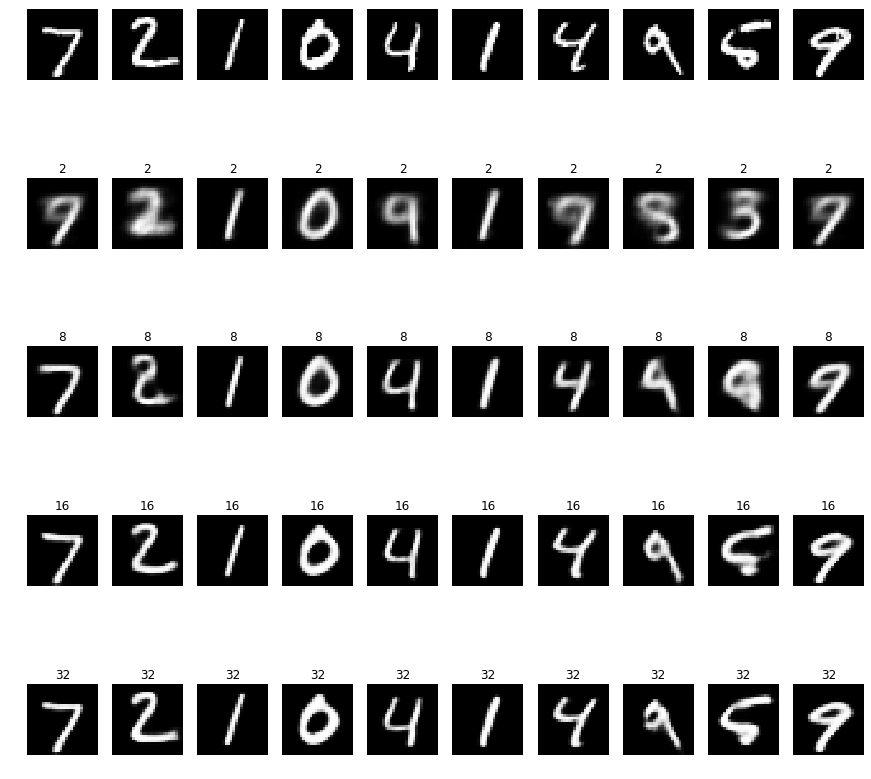

In [211]:
list_dim = [2,8,16,32]
deep_ae_list = []
deep_en_list = []
a = 0
plt.figure(figsize = (15,15))
for dim in list_dim:
  a = a +10
  ae,en,hi = ae_deep(x_train,x_val, dim, 20)
  #model3 = load_model('deep_autoencoder')
  deep_ae_list = deep_ae_list + [ae]
  #model4 = load_model('deep_encoder')
  deep_en_list = deep_en_list + [en]
  y_pred = ae.predict(x_test)
  y_encode = en.predict(x_test)
  for k in range(10):
    plt.subplot(5,10, k+1+a)
    plt.imshow(y_pred[k].reshape(28,28), cmap = 'gray')
    plt.title(str(dim))
    plt.axis('off')
for i in range(10):
  plt.subplot(5,10,i+1)
  plt.imshow(x_test[i].reshape(28,28), cmap='gray')
  plt.axis('off')

In [244]:
from skimage.measure import compare_ssim as ssim
alea = np.random.randint(low = 0, high = x_test.shape[0], size = (50,1))

list_conv = []
for i in alea:

  im_pred_conv = deep_ae_list[3].predict(x_test)
  #im_pred_sig = models_ae_list_sig[3].predict(x_test)
  score_conv = ssim(x_test[i[0]], im_pred_conv[i[0]], multichannel = True)
  list_conv = list_conv + [score_relu]
  #score_sig = ssim(x_test[i[0]], im_pred_sig[i[0]], multichannel = True)
  #list_sig = list_sig + [score_sig]
  
print(np.mean(list_relu), np.mean(list_conv))

0.8436111461303075 0.9142639560349979


#DEEP AUTOENCODER

Con el proposito de mejorar el desempeño de los autoencoder pasados, se procedió a utilizar capas convolucionales para reducir la dimensionalidad en el encoder. 
En base a los ploteos anterior se puede ver que el desempeño de la red para *d=2* es pobre pero mucho mejor que nuestro dos modelos exhibidos anteriormente, ya que la red logra captar de manera más paulatna las características más importantes de las imágenes. Aún así, ella tiende a confundir los 7 y 4 con 9; y lo que podría ser un 5 con un 3.

Para *d=8* se puede apreciar ya una mayor nitidez en las imágenes y casi nada de ruido, al contrario a lo que sucedía en los modelos anteriores, en los que se podían visulizar 'hoyos' en las imágenes. Al momento de reconstruir, igual tendió a confundir un 9 con un 4 y un 5 con 3. Pero sin duda alguna es una mejora a ambos modelos anteriores.

Para *d=16,32* se puede ver que las imágenes son muy nítidas, no poseen ruido como los casos anteriores y logran reconstruir casi perfectamente las imágenes entregadas. 

Se comparó el desempeño del modelo con **ReLu vs Deep AE** para d=32 (ya que fueron los mejores) y se obtuvo que el Deep AE logra mejorar en poca más del 7% al modelo denso. Por lo tanto se cumple lo esperado y es que la profundidad del modelo le entrega más flexibilidad a la red para poder entregar mejores resultados.

In [223]:
latent_dim = 32

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

for k in range(4):
  if k == 0:
    b=2
  else:
    b = 2**(k+2)
  pca = PCA(n_components= b)
  pca.fit(x_train.reshape(x_train.shape[0],784))
  pca_train = pca.transform(x_train.reshape(x_train.shape[0],784))
  pca_test = pca.transform(x_test.reshape(x_test.shape[0],784))

  knn = KNeighborsClassifier(10)
  start = time.time()
  knn.fit(pca_train,y_train)
  end = time.time()
  
  print('PCA = ', knn.score(pca_test,y_test))
  print('Tiempo ejecución = ', end - start)
  #encoder1 = Model(inputs=input_img, outputs=encoded)
  encoded_train = deep_en_list[k].predict(x_train)
  encoded_test = deep_en_list[k].predict(x_test)
  knn1 = KNeighborsClassifier(10)
  start1 = time.time()
  knn1.fit(encoded_train,y_train)
  end1 = time.time()
  print('Deep Encoded dim ', str(b), '= ', knn1.score(encoded_test, y_test))
  print('Tiempo ejecución = ', end1-start1)
  print('\n')
  

PCA =  0.4375
Tiempo ejecución =  0.02558112144470215
Deep Encoded dim  2 =  0.6314
Tiempo ejecución =  0.020963430404663086


PCA =  0.9007
Tiempo ejecución =  0.04567241668701172
Deep Encoded dim  8 =  0.9344
Tiempo ejecución =  0.030075788497924805


PCA =  0.9597
Tiempo ejecución =  0.06353592872619629
Deep Encoded dim  16 =  0.9665
Tiempo ejecución =  0.047762155532836914


PCA =  0.974
Tiempo ejecución =  0.11623311042785645
Deep Encoded dim  32 =  0.9719
Tiempo ejecución =  0.08847570419311523




#PCA VS DEEP AE

Al igual que antes, se compararon los desempeños de PCA para la reducción de dimensionalidad de las imágenes y se obtuvo que, para d=2 la deep ae supera ampliamente de la PCA (de hecho, con las imágenes anteriores es posible asumir esto ya que poseen una mejor visibilidad para el deep ae que para los ae densos). De hecho con DEEP AE logra dominar en cada uno de los casos y posee menos tiempo de ejecución que PCA. De hecho para d=32 funcionan parecido, simplemente distintas por un orden de 10^-3. Por lo tanto, la DEEP AE funciona mucho mejor que los modelos AE densos exhibidos y mejor que PCA en cuantoa desempeño y tiempo de ejecución.

Text(0.5, 1.0, 'Deep AE, con d=32')

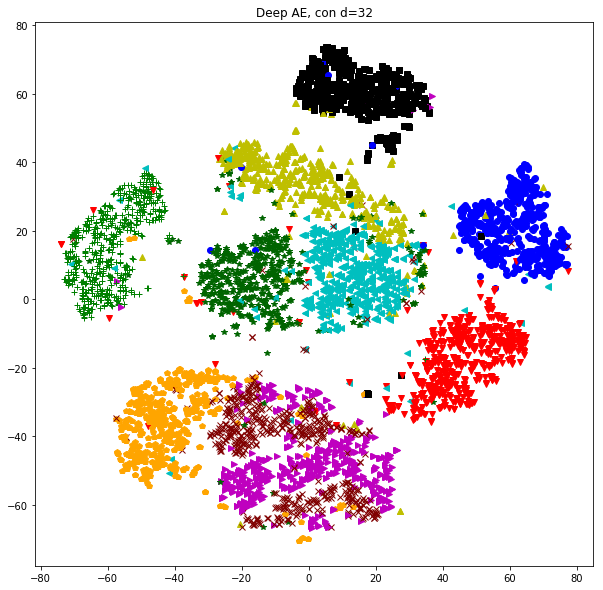

In [247]:
nplot=5000 #warning: mind your memory!
encoded_train = deep_en_list[3].predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
#plt.subplot(2,1,1)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.title('Deep AE, con d=32')



Text(0.5, 1.0, 'PCA, d=32')

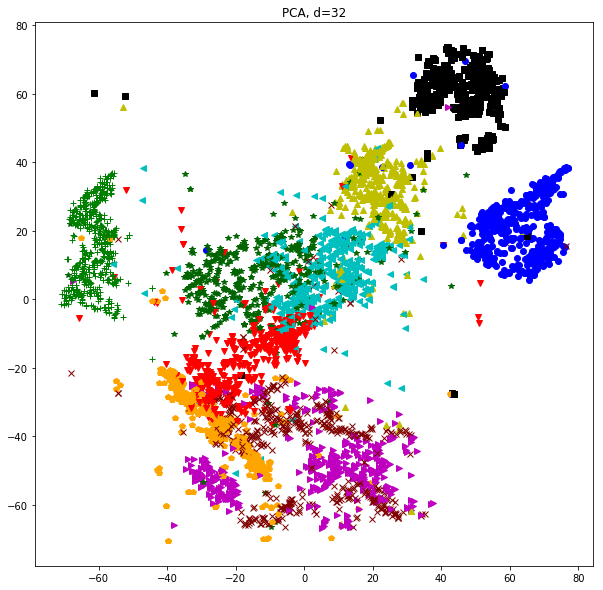

In [251]:
pca = PCA(n_components = 32)
pca.fit(x_train.reshape(x_train.shape[0],784))
pca_train = pca.transform(x_train.reshape(x_train.shape[0],784))
encoded_train1 = pca_train[:nplot]
model1 = TSNE(n_components =2 , random_state=0)
encoded_train1 = model1.fit_transform(encoded_train1)
plt.figure(figsize = (10,10))
#plt.subplot(2,1,2)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx1 in range(0,nplot):
  label1 = y_train[idx1]
  line = plt.plot(encoded_train1[idx1][0], encoded_train[idx1][1], color=colors[label1], marker=markers[label1], markersize = 6)
plt.title('PCA, d=32')

Text(0.5, 1.0, 'Dense AE - ReLu, con d=32')

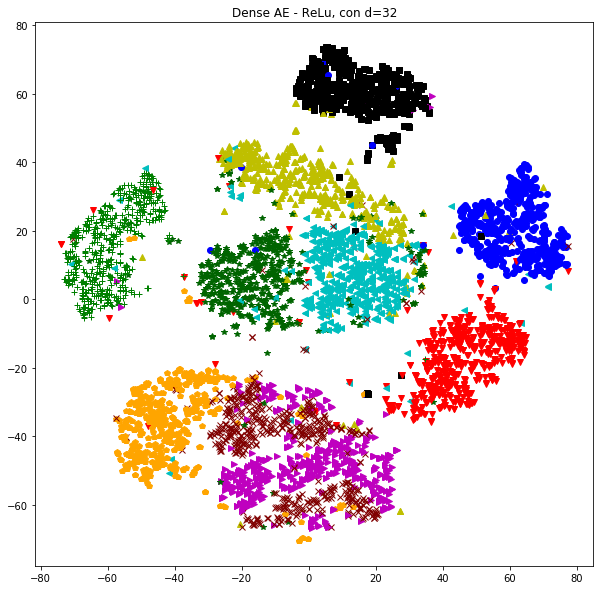

In [249]:
nplot=5000 #warning: mind your memory!
encoded_train2 = models_en_list[3].predict(x_train[:nplot])
from sklearn.manifold import TSNE
model2 = TSNE(n_components=2, random_state=0)
encoded_train2 = model.fit_transform(encoded_train2)
plt.figure(figsize=(10, 10))
#plt.subplot(2,1,1)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in range(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
plt.title('Dense AE - ReLu, con d=32')


#PLOTEO

Por último, se utilizó TSNE para poder plotear en dimensión 2 los resultados de, por un lado los encoders del *dense AE* y *deep AE* ; y por otro lado los de PCA.

El ploteo 1 y 3, de *DEEP AE* y *Dense AE*, respectivamente, logran clacifiar, para d=32, de la misma manera los números puestos en las imágenes. Visualmente el desempeño de ambos de similar. 
Para el ploteo 2, correspondientes al PCA, se logra ver que se confunden algunos números y los cluster, si bien están definidos, no logran verse por completo. En primera instancia no podemos decir que PCA funciona mal para d=32, debido a que el método TSNE intenta plotear imágenes en 32 dimensión a un en d=2. 